In [214]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor
import keras.api._v2.keras as keras
import tensorflow as tf
from keras.layers import Dense, Input, BatchNormalization, Dropout
from keras import Sequential
from keras import utils
from keras.activations import sigmoid
from xgboost import XGBRegressor
le = LabelEncoder()

**"Machine-Learning Mathematical Structures: Algebraic Geometry over the complex numbers."**

We will try to apply the ideas behind the article "Machine-Learning Mathematical Structures" by Yang-Hui He. For this, we will try to implement a Machine learning algorithm for each of the problem proposed in section 3. In this Jupyter Notebook we will focus on subsection 3.1 Warm-up.

Consider a complex polynomial. For simplycity consider that the coefficients are Gaussian integers in the range ±10±10i, and check if there is a root with multiplicity bigger than one.

 To start, we can restrict ourselves to the quadratic case and we can study if there is one or two roots on it. We generate 2*^10^6 random tuples (x[0], ..., x[5]) in our range which will represent our polynomial in the coefficientes x[0]+ix[1], x[2]+ix[3] and x[4]+ix[5]. 

In [215]:
Data = pd.DataFrame(np.random.randint(-10, 10, size = (2000000,6)), columns= ["a_0", "b_0", "a_1", "b_1", "a_2", "b_2"])
Data["MultRoots"] = Data.apply(lambda x : len(set(np.polynomial.Polynomial([complex(x["a_0"],x["b_0"]),complex(x["a_1"],x["b_1"]),complex(x["a_2"],x["b_2"])]).roots()))-1, axis = 1)
Data["MultRoots"].value_counts()

MultRoots
 1    1994933
 0       5058
-1          9
Name: count, dtype: int64

Since having only one root puts a restriction on the polynomial, it is normal that the ammount of them is smaller. We will define a function to create a balanced dataset. We also we do not want to consider the case that there are no roots.

In [216]:
Mult1 = Data[Data["MultRoots"] == 0]
Mult2 = Data[Data["MultRoots"] == 1].sample(n=len(Mult1))
DataCoeff = pd.concat([Mult1, Mult2], axis = 0, ignore_index = True)
DataCoeff = DataCoeff.sample(frac = 1, ignore_index = True)
print(DataCoeff)

       a_0  b_0  a_1  b_1  a_2  b_2  MultRoots
0        4    1   -3    3   -7   -4          1
1      -10   -8    0    2    0    0          0
2        9    6   -7   -6   -5   -7          1
3       -6    9   -3   -8   -5   -8          1
4       -5    6   -4   -2    1    8          1
...    ...  ...  ...  ...  ...  ...        ...
10111   -9   -3    4   -3    8    5          1
10112   -1    1    0   -2    4    4          1
10113    8   -7  -10    0    1    9          1
10114   -5   -5    2    1    4  -10          1
10115   -1    6    6    6    0    0          0

[10116 rows x 7 columns]


To finish preparing our data, we will asign the value 0 to means having one root, and the value 1 to means having 2 roots.

In [217]:
Data_Roots = DataCoeff.pop("MultRoots")
train_X, val_X, train_y, val_y = train_test_split(DataCoeff, Data_Roots, train_size = 0.8)

In [218]:
display(DataCoeff, Data_Roots)

,a_0,b_0,a_1,b_1,a_2,b_2
0,4,1,-3,3,-7,-4
1,-10,-8,0,2,0,0
2,9,6,-7,-6,-5,-7
3,-6,9,-3,-8,-5,-8
4,-5,6,-4,-2,1,8
...,...,...,...,...,...,...
10111,-9,-3,4,-3,8,5
10112,-1,1,0,-2,4,4
10113,8,-7,-10,0,1,9
10114,-5,-5,2,1,4,-10


0        1
1        0
2        1
3        1
4        1
        ..
10111    1
10112    1
10113    1
10114    1
10115    0
Name: MultRoots, Length: 10116, dtype: int64

With the data balanced, we can define our neural network.

In [219]:
model = keras.Sequential([
    Dense(128, activation='relu', input_shape=[6]),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout( 0.2),
    Dense(128, activation='relu'),
    Dropout( 0.2),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [220]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    train_X, train_y,
    validation_data=(val_X, val_y),
    batch_size=64,
    epochs=1000,
    callbacks=[early_stopping],
    verbose=0, # hide the output because we have so many epochs
)

Best Validation Loss: 50.0546
Best Validation Accuracy: 0.7619


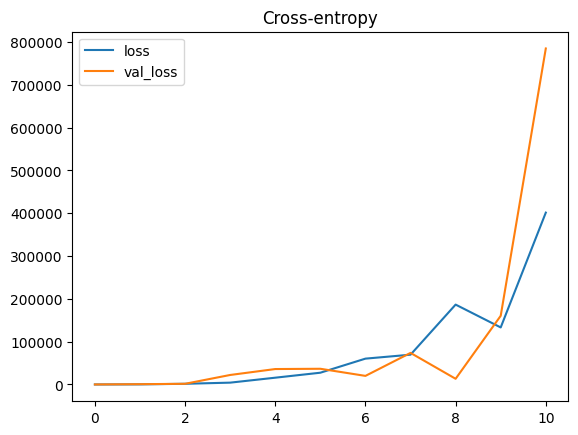

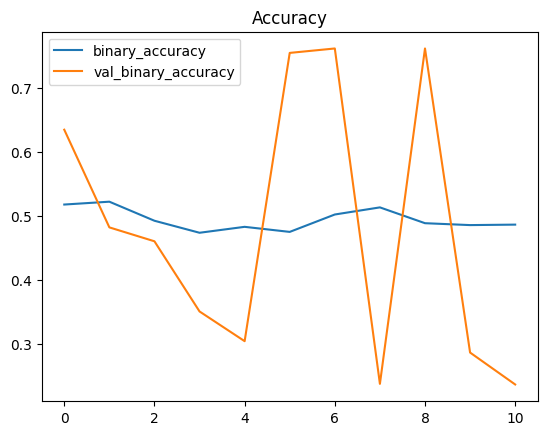

In [221]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

64/64 [==============================] - 1s 8ms/step


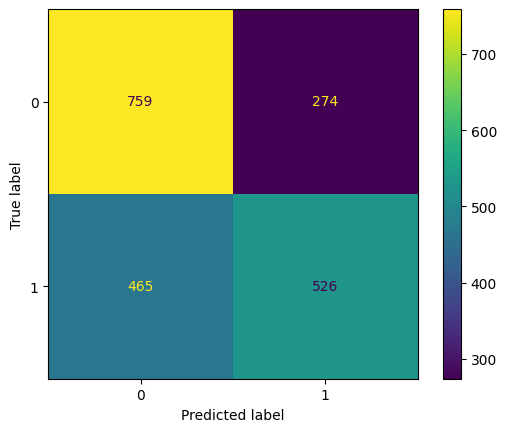

In [222]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(val_y, (model.predict(val_X) > 0.5).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()